# AUTOENCODER. DATASET SENTINEL 2SR 2017-2022

## 1. Carga del archivo de datos

El autoencoder está preparado para aceptar imágenes de 128x128 pixels con 12 bandas o canales. Los detalles del acceso al contenido al tfrecord se indican en la función `parse_example`. Lo idoneo es que el tfrecord contenga una cantidad adecuada imagenes (mas de 1000) al menos para que pueda ver a groso modo el funcionamiento de todo el entrenamiento.

In [5]:
path_tfrecord = 'ruta/del/archivo/tfrecord'

Para usar un archivo tfrecord es necesario crear una función extraiga la información necesaría de ese archivo. Por tanto es necesario conocer la estructura de los datos dentro del archivo para definir esta función. En este caso, extrae las imágenes y la reflectancia de las mismas se normaliza entre 0 y 1 de acuerdo al factor de escala que se indica en la descripción de la coleccion  sentinel 2SR de Google Earth Engine. Además las imagenes son mapeadas en bloques de 50 imágenes que es el tamaño de batch que se emplea en el tamño del modelo. La ventaja de usar un tfrecord es que las imágenes se van adquiriendo directamente del archivo en disco de acuerdo al tamaño de batch indicado, cosa que no ocurre con los TFDatasets, que son cargados por completo en memoria.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# 1. Leer los datos desde el archivo TFRecord
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.parse_tensor(parsed_example['image'], out_type=tf.float32)

    # Normalización de la imagen al rango [0,1]
    image = image / 10000.0

    return image, image  # Regresamos la imagen dos veces porque el autoencoder usa la misma imagen como entrada y objetivo

tfrecord_dataset = tf.data.TFRecordDataset(path_tfrecord).map(parse_example).batch(50)

## 2. Definición  del modelo de autoencoder

El autoencoder trata de extraer la información de la imágen y "comprimirla" en un espacio de dimensión inferior, o lo que es lo mismo en una estructura de matrices de igual tamaño que en conjunto tengan menos datos que la imagen inicial (menor dimensión). En este caso el espacio esta compuesto por 16 matrices de 3x3 (144 datos) en lugar de los 128x128x12 de la imagen inicial, pero podría haber sido también un vector con 128 o 256 datos (dimension 128x1x1 o 256x1x1. Las dimensión del espacio latente que resulte mas adecuada es algo que hay que descubrir probando diferentes opciones. 

In [11]:
input_shape = (None, None, 12)  # Asumiendo que tus imágenes tienen 12 canales y dimensiones variables

# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(12, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

## 3. Entrenamiento del modelo

Aquí se lleva a cabo el entrenamiento del modelo. En este ejemplo se ha definido Callback personalizado, que muestra el valor de la función de error con 6 decimales. Los Callbacks son la información que devuelve el framework de tensorflow durante el entrenamiento del modelo acerca su progreso y del valor de las métricas que se van dando. 

In [11]:
# Se define y callback personalizodo

class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss_value = logs.get('loss')
        if loss_value is not None:
            print(f'\nEpoch {epoch + 1}: loss = {loss_value:.6f}')  # Mostrar el loss con 6 decimales

# Crear una instancia del callback
print_loss_callback = PrintLossCallback()

# Entrenar el modelo con el callback personalizado
autoencoder.fit(tfrecord_dataset, epochs=5, callbacks=[print_loss_callback])

Epoch 1/5
    288/Unknown - 180s 619ms/step - loss: 0.0112
Epoch 1: loss = 0.011182
288/288 [==============================] - 180s 620ms/step - loss: 0.0112
Epoch 2/5
288/288 [==============================] - ETA: 0s - loss: 0.0021
Epoch 2: loss = 0.002126
288/288 [==============================] - 177s 615ms/step - loss: 0.0021
Epoch 3/5
288/288 [==============================] - ETA: 0s - loss: 0.0018
Epoch 3: loss = 0.001760
288/288 [==============================] - 176s 612ms/step - loss: 0.0018
Epoch 4/5
288/288 [==============================] - ETA: 0s - loss: 0.0016
Epoch 4: loss = 0.001632
288/288 [==============================] - 180s 623ms/step - loss: 0.0016
Epoch 5/5
288/288 [==============================] - ETA: 0s - loss: 0.0016
Epoch 5: loss = 0.001581
288/288 [==============================] - 182s 631ms/step - loss: 0.0016


## 4. Visualización de resultados

En el caso de los autoencoder y en general en modelos que reconstruyen o generan imágenes es muy recomendables visualizar los resultados ya que las funcion de pérdida, si bien cuantifica el error cometido por el modelo, no llegan a captar del todo la calidad en la reconstrucción de la imagen. No obstante, al alcanzar un resultado satisfactorio se podrán calibrar el valor de la función perdida que se ajusta a la calidad requirida. Por otro lado en la implementación hecha la imagen a representar es cogida al azar a partir de una muestra de 100 imágenes.

2/2 [==============================] - 0s 107ms/step


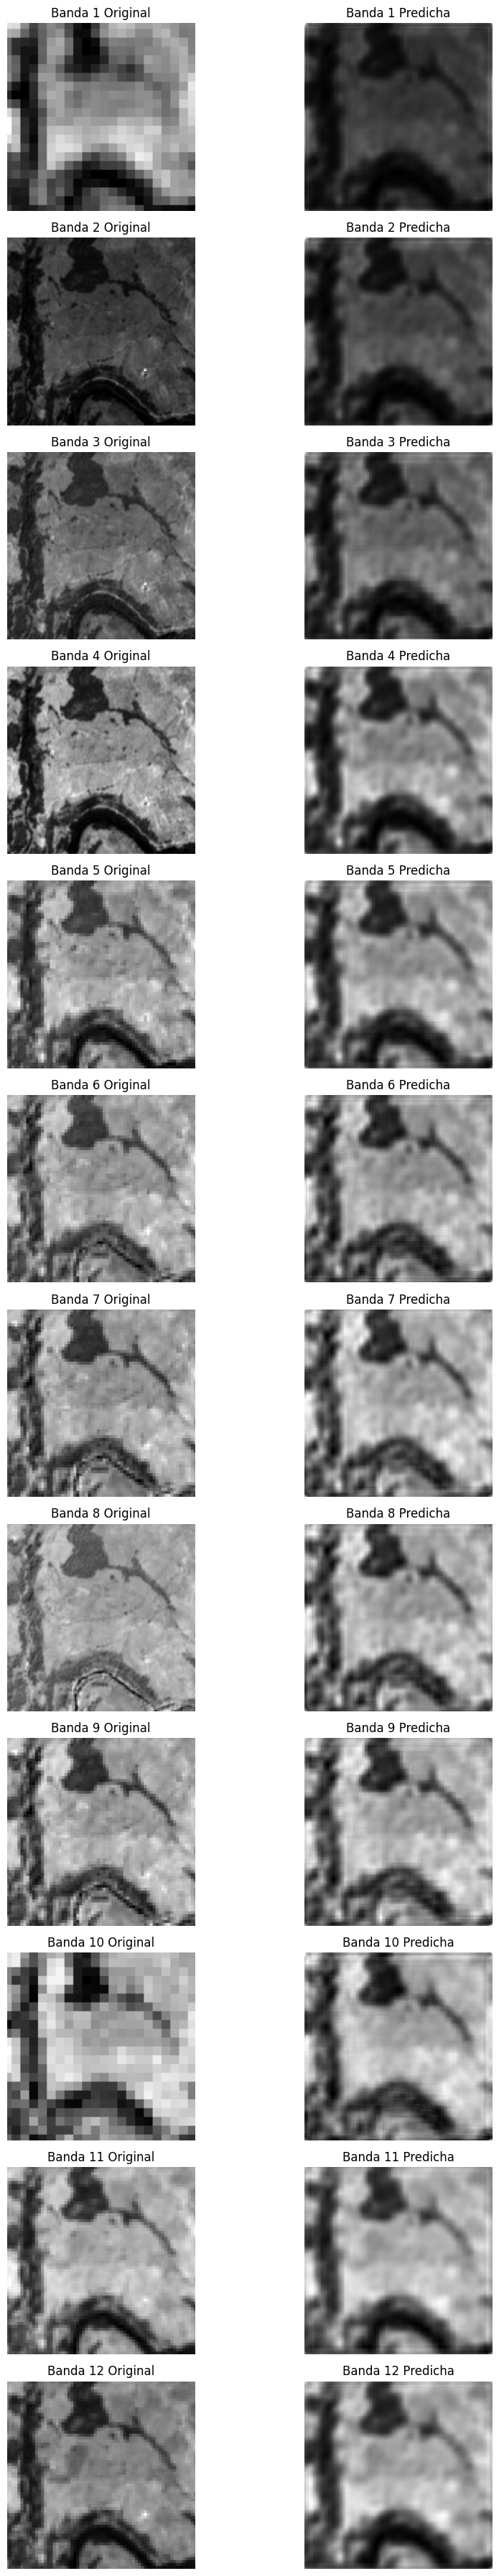

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Tomar una imagen al azar del conjunto de datos
for original_image, _ in tfrecord_dataset.shuffle(buffer_size=100).take(1):
    break

# Obtener la imagen predicha usando el modelo entrenado
predicted_image = autoencoder.predict(original_image)

# Visualizar cada banda
num_bands = 12
fig, axes = plt.subplots(num_bands, 2, figsize=(10, 3*num_bands))

for i in range(num_bands):
    # Visualizar la banda i de la imagen original
    axes[i, 0].imshow(original_image[0, :, :, i], cmap='gray')
    axes[i, 0].set_title(f'Banda {i+1} Original')
    axes[i, 0].axis('off')

    # Visualizar la banda i de la imagen predicha
    axes[i, 1].imshow(predicted_image[0, :, :, i], cmap='gray')
    axes[i, 1].set_title(f'Banda {i+1} Predicha')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
